# This script combines all of the crops from the department of agriculture into one massive file

In [121]:
import pandas as pd
from bs4 import BeautifulSoup
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# Modifications to make
- Year -> DNL Source Year
- Take first year of range and make it the 'Year' column (except maybe for summer? ask Gary)
- Remove numbers from State and District Columns
- State -> Admin 1 and District -> Admin 2 (with state initials in parentheses)
- Add start and end periods
    - Kharif = 6/1 - 9/30
    - Autumn = 9/1 - 10/31
    - Rabi = 10/1 - 1/31
    - Winter = 12/15 - 3/15
    - Summer = 3/15 - 5/31
    - Whole Year = self explanatory (but ask Gary about year)
- Add crop codes
- Add production style (all for everything)
- Crop -> Source Crop
- Area (hectare) -> Area Harvested: ha
- Yield (Tonne/ha) -> Yield: MT/ha
- Production (Tonnes) -> Quantity Produced: MT
- Area Planted = NA
- Data Source Organization = MoA & FW, India
- Data Source Document = Official agricultural statistics, India, crop
- Publication Name = https://data.desagri.gov.in/website/crops-apy-report-web, extracted Feb 2025, India
- Survey Type = crop_final
- Country = IN
- FNID = (leave blank for now I think)

In [122]:
def read_file(filename):
    # Read the file as text
    with open(filename, 'r', encoding='utf-8') as file:
        content = file.read()

    # Parse the HTML
    soup = BeautifulSoup(content, 'html.parser')
    table = soup.find('table')

    # Convert to pandas DataFrame
    df = pd.read_html(str(table))[0]

    # Clean up any potential messy data
    df = df.replace({r'\s+$': ''}, regex=True)  # Remove trailing whitespace
    df = df.replace({r'^\s+': ''}, regex=True)  # Remove leading whitespace

    return df

In [123]:
def restack(df):
    # Keep the first three columns as they are
    id_cols = df.iloc[:, :3].copy()  # State, District, Year
    id_cols.columns = ['State', 'District', 'Year']  # Flatten these column names

    # Get the measurement columns (everything except first three)
    measure_cols = df.iloc[:, 3:]

    # Stack only crop and season levels, keeping indicators as columns
    stacked = (measure_cols
        .stack(level=0, dropna=False)  # Stack first level (Crop)
        .stack(level=0, dropna=False)  # Stack second level (Season)
    )

    # Convert to DataFrame and reset index
    stacked_df = stacked.reset_index()

    # Rename the columns appropriately
    stacked_df = stacked_df.rename(columns={
        'level_1': 'Crop',
        'level_2': 'Season',
        0: 'Area (Hectare)',
        1: 'Production (Tonnes)',
        2: 'Yield (Tonne/Hectare)'
    })

    # Create final dataframe
    final_df = pd.concat([
        id_cols.loc[stacked_df['level_0']].reset_index(drop=True),
        stacked_df.drop('level_0', axis=1)
    ], axis=1)

    #Remove rows with all NaN values
    final_df = clean_df(final_df)

    # Sort the data
    final_df = final_df.sort_values(['State', 'District', 'Year', 'Crop', 'Season'])

    # Reset the index for clean output
    final_df = final_df.reset_index(drop=True)

    return final_df

In [124]:
def clean_df(df):
    # Remove rows where all values are missing
    # Keep only rows where at least one of Area, Production, or Yield is not NaN
    df = df.dropna(
        subset=['Area (Hectare)', 'Production (Tonnes)', 'Yield (Tonne/Hectare)'],
        how='all'
    )

    return df

In [125]:
def add_state_abbr(final_df):
    #Add state abbreviations
    abbr_map = {
    'Andhra Pradesh': '(AP)',
    'Arunachal Pradesh': '(AR)',
    'Assam': '(AS)',
    'Bihar': '(BR)',
    'Chhattisgarh': '(CG)',
    'Goa': '(GA)',
    'Gujarat': '(GJ)',
    'Haryana': '(HR)',
    'Himachal Pradesh': '(HP)',
    'Jharkhand': '(JH)',
    'Jammu and Kashmir': '(JK)',
    'Karnataka': '(KA)',
    'Kerala': '(KL)',
    'Madhya Pradesh': '(MP)',
    'Maharashtra': '(MH)',
    'Manipur': '(MN)',
    'Meghalaya': '(ML)',
    'Mizoram': '(MZ)',
    'Nagaland': '(NL)',
    'Odisha': '(OD)',
    'Punjab': '(PB)',
    'Rajasthan': '(RJ)',
    'Sikkim': '(SK)',
    'Tamil Nadu': '(TN)',
    'Telangana': '(TG)',
    'Tripura': '(TR)',
    'Uttar Pradesh': '(UP)',
    'Uttarakhand': '(UK)',
    'West Bengal': '(WB)',
    'Andaman and Nicobar Islands': '(AN)',
    'Chandigarh': '(CH)',
    'The Dadra & Nagar Haveli and Daman and Diu': '(DD)',
    'The Dadra and Nagar Haveli and Daman and Diu': '(DD)',
    'Dadra and Nagar Haveli and Daman and Diu': '(DD)',
    'Dadra and Nagar Haveli': '(DN)',
    'Daman and Diu': '(DA)',
    'Delhi': '(DL)',
    'Ladakh': '(LA)',
    'Lakshadweep': '(LD)',
    'Puducherry': '(PY)'
    }

    final_df['District'] = final_df['District'] + ' ' + final_df['State'].map(abbr_map)

    return final_df

In [126]:
# Function to create date based on year and season
def get_period_dates(row):
    #Add in season information
    # Kharif = 6/1 - 9/30
    # - Autumn = 9/1 - 10/31
    # - Rabi = 10/1 - 1/31 #must go to next year for Rabi
    # - Winter = 12/15 - 3/15
    # - Summer = 3/15 - 5/31
    season_dates = {
        'Summer': {'start_month': 3, 'start_day': 15, 'end_month': 5, 'end_day': 31},
        'Winter': {'start_month': 12, 'start_day': 15, 'end_month': 3, 'end_day': 15},  # example
        'Rabi': {'start_month': 10, 'start_day': 1, 'end_month': 1, 'end_day': 31},    # example
        'Kharif': {'start_month': 6, 'start_day': 1, 'end_month': 9, 'end_day': 30},   # example
        'Autumn': {'start_month': 9, 'start_day': 1, 'end_month': 10, 'end_day': 31},  # example
        'Whole Year': {'start_month': 1, 'start_day': 1, 'end_month': 12, 'end_day': 31}
    }

    year = int(row['Year'])
    season = row['Season'].strip().title()
    
    season_info = season_dates[season]
    
    start_date = pd.Timestamp(
        year=year,
        month=season_info['start_month'],
        day=season_info['start_day']
    ).strftime('%-m/%-d/%Y')  # formats as m/d/yyyy without leading zeros
    
    end_year = year + 1 if season in ('Winter', 'Rabi') and season_info['end_month'] < season_info['start_month'] else year
    
    end_date = pd.Timestamp(
        year=end_year,
        month=season_info['end_month'],
        day=season_info['end_day']
    ).strftime('%-m/%-d/%Y')
    
    return pd.Series({'Start Period': start_date, 'End Period': end_date})


In [127]:
def add_season(final_df):
    # Convert Year to integer, handling any potential issues
    final_df['Year'] = pd.to_numeric(final_df['Year'], errors='coerce')

    # Clean up Season column - strip whitespace and convert to lowercase
    final_df['Season'] = final_df['Season'].str.strip().str.title()

    final_df[['Start Period', 'End Period']] = final_df.apply(get_period_dates, axis=1)

    return final_df

In [128]:
def district_fix(final_df):
    district_mapping = {
    # Format: 'New name': 'Old name'
    '24 Paraganas North (WB)': 'North Twenty-four Paraganas (WB)',
    '24 Paraganas South (WB)': 'South Twenty-four Paraganas (WB)',
    'Ahmadabad (GJ)': 'Ahmedabad (GJ)',
    'Anugul (OD)': 'Angul (OD)',
    'Baghpat (UP)': 'Bagpat (UP)',
    'Bellary (KA)': 'Ballari (KA)',
    'Badgam (JK)': 'Budgam (JK)',
    'Baleshwar (OD)': 'Balasore (OD)',
    'Balrampur (CG)': 'Balrampur-Ramanujganj (CG)',
    'Banas Kantha (GJ)': 'Banaskantha (GJ)',
    'Bangalore Rural (KA)': 'Bengaluru Rural (KA)',
    'Barabanki (UP)': 'Bara Banki (UP)',
    'Baramulla (JK)': 'Baramula (JK)',
    'Belgaum (KA)': 'Belagavi (KA)',
    'Bhadradri (TG)': 'Bhadradri Kothagudem (TG)',
    'Chhotaudepur (GJ)': 'Chhota Udaipur (GJ)',
    'Coochbehar (WB)': 'Koch Bihar (WB)',
    'Dakshin Kannad (KA)': 'Dakshina Kannada (KA)',
    'Dang (GJ)': 'Dangs (GJ)',
    'Davangere (KA)': 'Davanagere (KA)',
    'Deogarh (OD)': 'Debagarh (OD)',
    'Dinajpur Dakshin (WB)': 'Dakshin Dinajpur (WB)',
    'Dinajpur Uttar (WB)': 'Uttar Dinajpur (WB)',
    'Dohad (GJ)': 'Dahod (GJ)',
    'East Singhbum (JH)': 'Purba Singhbhum (JH)',
    'Faizabad (UP)': 'Ayodhya (UP)',
    'Firozepur (PB)': 'Firozpur (PB)',
    'Ganganagar (RJ)': 'Sri Ganganagar (RJ)',
    'Gariyaband (CG)': 'Gariaband (CG)',
    'Geyzing (SK)': 'Gyalshing (SK)',
    'Gondia (MH)': 'Gondiya (MH)',
    'Jagatsinghapur (OD)': 'Jagatsinghpur (OD)',
    'Jagitial (TG)': 'Jagtial (TG)',
    'Jajapur (OD)': 'Jajpur (OD)',
    'Jangoan (TG)': 'Jangaon (TG)',
    'Jayashankar (TG)': 'Jayashankar Bhupalpally (TG)',
    'Jogulamba (TG)': 'Jogulamba Gadwal (TG)',
    'Kaimur (Bhabua) (BR)': 'Kaimur (BR)',
    'Kamrup (AS)': 'Kamrup Rural (AS)',
    'Kamrup Metro (AS)': 'Kamrup Metropolitan (AS)',
    'Kanniyakumari (TN)': 'Kanyakumari (TN)',
    'Kanpur Nagar (UP)': 'Ramabai Nagar (UP)',
    'Kasaragod (KL)': 'Kasargod (KL)',
    'Khairgarh Chhuikhadan Gandai (CG)': 'Khairagarh (CG)',
    'Kheri (UP)': 'Lakhimpur Kheri (UP)',
    'Komaram Bheem Asifabad (TG)': 'Kumuram Bheem Asifabad (TG)',
    'Korea (CG)': 'Koriya (CG)',
    'Kushi Nagar (UP)': 'Kushinagar (UP)',
    'Lahul And Spiti (HP)': 'Lahaul and Spiti (HP)',
    'Leh Ladakh (LA)': 'Leh (LA)',
    'Leparada (AR)': 'Lepa Rada (AR)',
    'Maldah (WB)': 'Malda (WB)',
    'Manendragarh Chirimiri Bharatpur (CG)': 'Manendragarh (CG)',
    'Medchal (TG)': 'Medchal-Malkajgiri (TG)',
    'Medinipur East (WB)': 'Purba Medinipur (WB)',
    'Medinipur West (WB)': 'Paschim Medinipur (WB)',
    'Mewat (HR)': 'Nuh (HR)',
    'Mohla Manpur Ambagarh Chouki (CG)': 'Mohla-Manpur (CG)',
    'Muktsar (PB)': 'Sri Muktsar Sahib (PB)',
    'Muzaffarpur (BR)': 'Muzzafarpur (BR)',
    'Narayanapet (TG)': 'Narayanpet (TG)',
    'Nawanshahr (PB)': 'Shahid Bhagat Singh Nagar (PB)',
    'North And Middle Andaman (AN)': 'North and Middle Andaman (AN)',
    'Ntr (AP)': 'NT Rama Rao (AP)',
    'Nuiland (NL)': 'Niuland (NL)',
    'Pakke Kessang (AR)': 'Pakke Kesang (AR)',
    'Panch Mahals (GJ)': 'Panchmahal (GJ)',
    'Pashchim Champaran (BR)': 'Paschim Champaran (BR)',
    'Purbi Champaran (BR)': 'Purba Champaran (BR)',
    'Rae Bareli (UP)': 'Raebareli (UP)',
    'Rajanna (TG)': 'Rajanna Sircilla (TG)',
    'Rangareddi (TG)': 'Ranga Reddy (TG)',
    'Ri Bhoi (ML)': 'Ri-Bhoi (ML)',
    'S.A.S Nagar (PB)': 'Sahibzada Ajit Singh Nagar (PB)',
    'Sabar Kantha (GJ)': 'Sabarkantha (GJ)',
    'Sahebganj (JH)': 'Sahibganj (JH)',
    'Saiha (MZ)': 'Siaha (MZ)',
    'Sakti (CG)': 'Shakti (CG)',
    'Sant Kabeer Nagar (UP)': 'Sant Kabir Nagar (UP)',
    'Sant Ravidas Nagar (UP)': 'Bhadohi (UP)',
    'Saraikela Kharsawan (JH)': 'Seraikela Kharsawan (JH)',
    'Sarangarh Bilaigarh (CG)': 'Sarangarh-Bilaigarh (CG)',
    'Sepahijala (TR)': 'Sipahijala (TR)',
    'Sonepur (OD)': 'Subarnapur (OD)',
    'South Salmara Mancachar (AS)': 'South Salmara-Mankachar (AS)',
    'Spsr Nellore (AP)': 'Nellore (AP)',
    'The Nilgiris (TN)': 'Nilgiris (TN)',
    'Thenkasi (TN)': 'Tenkasi (TN)',
    'Thiruvallur (TN)': 'Tiruvallur (TN)',
    'Tirupathur (TN)': 'Tirupattur (TN)',
    'Udam Singh Nagar (UK)': 'Udham Singh Nagar (UK)',
    'Uttar Kashi (UK)': 'Uttarkashi (UK)',
    'Vijayanagar (KA)': 'Vijayanagara (KA)',
    'Visakhapatanam (AP)': 'Visakhapatnam (AP)',
    'West Singhbhum (JH)': 'Paschim Singhbhum (JH)',
    'Yadadri (TG)': 'Yadadri Bhuvanagiri (TG)',
    'Yadgir (KA)': 'Yadagiri (KA)',
    'Yamunanagar (HR)': 'Yamuna Nagar (HR)',
    'nan': 'NA'
    }

    final_df['District'] = final_df['District'].replace(district_mapping)

    return final_df

In [129]:
def renaming(final_df):
    #First we rename the Area, Yield, and Production columns
    final_df.rename(columns={'Area (Hectare)': 'Area Harvested: ha', 'Production (Tonnes)': 'Quantity Produced: MT', 'Yield (Tonne/Hectare)': 'Yield: MT/ha'}, inplace=True)

    #Fix numbers in state and district columns
    final_df['State'] = final_df['State'].str.split('.', n=1).str[1].str.strip()
    final_df['District'] = final_df['District'].str.split('.', n=1).str[1].str.strip()
    final_df['District'] = final_df['District'].str.title()

    #Add state abbreviations
    final_df = add_state_abbr(final_df)

    #Change district names to common spellings from Gary's file
    final_df = district_fix(final_df)

    print(np.sort(final_df['District'].unique().astype(str)))

    #Establish source year column
    final_df['DNL_Source_year'] = final_df['Year'].str.replace(' ','')
    final_df['DNL_Source_year'] = final_df['DNL_Source_year'].apply(lambda s: s[:4] + '-' + s[-2:])
    final_df['Year'] = final_df['Year'].str.split('-', n=1).str[0].str.strip()

    #Rename state and district columns
    final_df.rename(columns={'State': 'Admin 1', 'District': 'Admin 2'}, inplace=True)

    #Add in FEWS metadata
    final_df['Admin 3'] = ''
    final_df['Country'] = 'IN'
    final_df['Survey Type'] ='crop_final'
    final_df['Data Source Organization'] = 'MoA & FW, India'
    final_df['Data Source Document'] = 'Official agricultural statistics, India, crop'
    final_df['Publication Name'] = 'https://data.desagri.gov.in/website/crops-apy-report-web, extracted Feburary 2025, India'
    final_df['FNID'] = ''
    final_df['Dominant Production System'] = 'All (PS)'
    final_df['Area Planted: ha'] = 'NA'
    final_df['Contributions by'] = 'Harvard'
    final_df['Start Period'] = ''
    final_df['End Period'] = ''
    final_df['Zone'] = ''

    #Rename crop columns
    final_df.rename(columns={'Crop': 'Source crop'}, inplace=True)
    final_df['Crop'] = ''
    
    #Reorder columns
    final_df = final_df.loc[:, ['Data Source Organization', 'Data Source Document', 'Publication Name',
    'Survey Type', 'Country', 'Zone', 'FNID', 'Admin 1', 'Admin 2', 'Admin 3', 'Year', 'Start Period', 'Season', 'End Period',
    'Crop', 'Dominant Production System', 'Area Planted: ha', 'Area Harvested: ha', 'Yield: MT/ha', 'Quantity Produced: MT', 
    'Contributions by', 'Source crop', 'DNL_Source_year']]

    #Add in season information
    final_df = add_season(final_df)

    # Convert types in main dataframe
    final_df['Area Harvested: ha'] = pd.to_numeric(final_df['Area Harvested: ha'], errors='coerce').round(2)
    final_df['Yield: MT/ha'] = pd.to_numeric(final_df['Yield: MT/ha'], errors='coerce').round(2)
    final_df['Quantity Produced: MT'] = pd.to_numeric(final_df['Quantity Produced: MT'], errors='coerce').round(2)

    return final_df

In [130]:
def overlap_check(old_df, final_df):
    # Check for overlap
    check_columns = ['Admin 1', 'Admin 2', 'Year', 'Source crop', 'Season']
    
    # Convert year in test dataframe (already float for others)
    old_df['Year'] = old_df['Year'].astype(int)
    old_df['Area Harvested: ha'] = pd.to_numeric(old_df['Area Harvested: ha'], errors='coerce').round(2)
    old_df['Yield: MT/ha'] = pd.to_numeric(old_df['Yield: MT/ha'], errors='coerce').round(2)
    old_df['Quantity Produced: MT'] = pd.to_numeric(old_df['Quantity Produced: MT'], errors='coerce').round(2)

    # Now try the merge
    matches = final_df.merge(
        old_df, 
        on=check_columns,
        indicator=True,
        how='left'
    )

    # Count matches and non-matches
    match_stats = matches['_merge'].value_counts()

    print("\nResults:")
    print(f"Total rows in test dataset: {len(final_df)}")
    print(f"Number of matching rows: {sum(matches['_merge'] == 'both')}")
    print(f"Number of non-matching rows: {sum(matches['_merge'] == 'left_only')}")
    print(f"Percentage of test rows found in main dataset: {(sum(matches['_merge'] == 'both') / len(final_df)) * 100:.2f}%")

In [131]:
def merge_tables(old_df, final_df):
    # First, let's create a list of columns to check for duplicates
    check_columns = ['Admin 1', 'Admin 2', 'Year', 'Source crop', 'Season']
                    # 'Area Harvested: ha', 'Yield: MT/ha', 'Quantity Produced: MT']
                    #Decided not to check on data because I noticed some discrepancies. My numbers seem more accurate, so we will only take mine.
    
    #Combine and drop duplicates that match in that subset
    combined_df = pd.concat([old_df, final_df], ignore_index=True)
    combined_df = combined_df.drop_duplicates(subset=check_columns, keep='last')

    return combined_df

In [132]:
#Load in full data and see how much overlap there is
old_df = pd.read_excel('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/old_agstats/IN_AgStatsFeb2025_Gary.xlsx') 

In [133]:
#Grab all files in the directory except the banana one which we already did
os.chdir('/Users/michaelfoley/Google Drive/My Drive/Subnational_Yield_Database/data/raw/IND/')

all_files = glob.glob('*.xls')
#new_files = list(filter(lambda x: 'banana' not in x, all_files))

In [134]:
for file in all_files:
    current_crops = file.split('.')[0].split('/')[-1]
    print(f'\nWorking on {current_crops}')

    #Read in
    df = read_file(file)
    final_df = restack(df)
    final_df = renaming(final_df)

    #Check for overlap
    overlap_check(old_df, final_df)

    #Merge
    old_df = merge_tables(old_df, final_df)

    #Save
    old_df.to_csv(f'/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/scripts/country/IND/ag_save_{current_crops}.csv',
    index=False)


Working on ragi_barley_wheat_smallmillets


/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Allahabad (UP)' 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)'
 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)'
 'Amreli (GJ)' 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)'
 'Anand (GJ)' 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipora (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatl

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ajmer (RJ)' 'Alappuzha (KL)' 'Aligarh (UP)' 'Alirajpur (MP)'
 'Allahabad (UP)' 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)'
 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amreli (GJ)'
 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)' 'Anantapur (AP)'
 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)' 'Annamayya (AP)' 'Anuppur (MP)'
 'Araria (BR)' 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)'
 'Auraiya (UP)' 'Aurangabad (BR)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)' 'Bapatla (AP)'
 'Bara Banki (UP)' 'Baramula (JK)' 'Baran (RJ)' 'Bareilly (UP)'
 'Bargarh (OD)' 'Barmer (RJ)' 'Barpeta (AS)' 'Barwani (MP)' 'Bastar (CG)'
 'B

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Allahabad (UP)' 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)'
 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)'
 'Amreli (GJ)' 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)'
 'Anand (GJ)' 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipora (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatl

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agra (UP)' 'Ahmedabad (GJ)' 'Aizawl (MZ)' 'Ajmer (RJ)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Allahabad (UP)' 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)'
 'Ambala (HR)' 'Amreli (GJ)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Annamayya (AP)'
 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)' 'Ariyalur (TN)' 'Arwal (BR)'
 'Ashoknagar (MP)' 'Aurangabad (BR)' 'Bagalkot (KA)' 'Bageshwar (UK)'
 'Bahraich (UP)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipora (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatla (AP)' 'Bara Banki (UP)' 'Baramula (JK)' 'Baran (RJ)'
 'Bareilly (UP)' 'Bargarh (OD)' 'Barmer (RJ)' 'Barwani (MP)' 'Bastar (CG)'
 'Bathinda (PB)' 'Begusarai (BR)' 'Belagavi (KA)' 'Bemetara (CG)'
 'Bengaluru Rural (KA)' 'Beng

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)' 'Aligarh (UP)'
 'Alipurduar (WB)' 'Alirajpur (MP)' 'Allahabad (UP)' 'Almora (UK)'
 'Alwar (RJ)' 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)'
 'Amravati (MH)' 'Amreli (GJ)' 'Amritsar (PB)' 'Amroha (UP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipora (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatla (AP)' 'Bara Banki (UP)' 'Baramula (JK)' 'Baran (RJ)'
 'Bareilly

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)' 'Aligarh (UP)'
 'Alipurduar (WB)' 'Alirajpur (MP)' 'Allahabad (UP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Amravati (MH)' 'Amreli (GJ)' 'Amritsar (PB)' 'Amroha (UP)'
 'Anakapalli (AP)' 'Anand (GJ)' 'Anantapur (AP)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Azamgarh (UP)' 'Bagalkot (KA)'
 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)' 'Baksa (AS)'
 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)' 'Ballari (KA)'
 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)' 'Banda (UP)' 'Banka (BR)'
 'Bankura (WB)' 'Banswara (RJ)' 'Bapatla (AP)' 'Bara Banki (UP)'
 'Baran (RJ)' 'Bareilly (UP)' 'Bargarh (OD)' 'Barmer (RJ)' 'Barnala (PB)'
 'Barpeta (AS)' 'Bar

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Allahabad (UP)' 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)'
 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)'
 'Amreli (GJ)' 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)'
 'Anand (GJ)' 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipora (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatl

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Aizawl (MZ)' 'Ajmer (RJ)' 'Alappuzha (KL)' 'Aligarh (UP)'
 'Alipurduar (WB)' 'Alirajpur (MP)' 'Allahabad (UP)'
 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amreli (GJ)' 'Amroha (UP)'
 'Anakapalli (AP)' 'Anand (GJ)' 'Anantapur (AP)' 'Anantnag (JK)'
 'Angul (OD)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)' 'Ariyalur (TN)'
 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)' 'Aurangabad (BR)'
 'Ayodhya (UP)' 'Azamgarh (UP)' 'Bagalkot (KA)' 'Bageshwar (UK)'
 'Bagpat (UP)' 'Bahraich (UP)' 'Baksa (AS)' 'Balaghat (MP)'
 'Balangir (OD)' 'Balasore (OD)' 'Ballari (KA)' 'Ballia (UP)'
 'Baloda Bazar (CG)' 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)'
 'Banaskantha (GJ)' 'Banda (UP)' 'Banka (BR)' 'Bankura (WB)'
 'Banswara (RJ)' 'Bapatla (AP)' 'Bara Banki (UP)' 'Baran (RJ)'
 'Bareilly (UP)' 'Bargarh (OD)' 'Barmer (RJ)' 'Barpeta (AS)'
 'Barwani (MP)' 'Bastar (CG)' 'Basti (UP)' 

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Allahabad (UP)' 'Alluri Sitharama Raju (AP)' 'Alwar (RJ)' 'Ambala (HR)'
 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)' 'Amreli (GJ)'
 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Ariyalur (TN)'
 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)' 'Aurangabad (BR)'
 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)' 'Bagalkot (KA)'
 'Bagpat (UP)' 'Bahraich (UP)' 'Baksa (AS)' 'Balaghat (MP)'
 'Balangir (OD)' 'Balasore (OD)' 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)'
 'Baloda Bazar (CG)' 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)'
 'Banaskantha (GJ)' 'Banda (UP)' 'Banka (BR)' 'Bankura (WB)'
 'Banswara (RJ)' 'Bapatla (AP)' 'Bara Banki (UP)' 'Baran (RJ)'
 'Bareilly (UP)' 'Bargarh 

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Ajmer (RJ)' 'Akola (MH)' 'Alappuzha (KL)'
 'Aligarh (UP)' 'Alirajpur (MP)' 'Allahabad (UP)' 'Alwar (RJ)'
 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)'
 'Amreli (GJ)' 'Amroha (UP)' 'Anakapalli (AP)' 'Anand (GJ)'
 'Anantapur (AP)' 'Angul (OD)' 'Annamayya (AP)' 'Anuppur (MP)'
 'Araria (BR)' 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)'
 'Auraiya (UP)' 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)'
 'Azamgarh (UP)' 'Bagalkot (KA)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)' 'Bapatla (AP)'
 'Bara Banki (UP)' 'Baran (RJ)' 'Bareilly (UP)' 'Bargarh (OD)'
 'Barmer (RJ)' 'Barpeta (AS)' 'Barwani (MP)' 'Bastar (CG)' 'Basti (UP)'
 'Beed (MH)' 'Begusarai (BR)' 

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Allahabad (UP)' 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)'
 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)'
 'Amreli (GJ)' 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)'
 'Anand (GJ)' 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipora (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatl

/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/1378215583.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0, dropna=False)  # Stack first level (Crop)
/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/3153344820.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation a

['Adilabad (TG)' 'Agar Malwa (MP)' 'Agra (UP)' 'Ahmedabad (GJ)'
 'Ahmednagar (MH)' 'Aizawl (MZ)' 'Ajmer (RJ)' 'Akola (MH)'
 'Alappuzha (KL)' 'Aligarh (UP)' 'Alipurduar (WB)' 'Alirajpur (MP)'
 'Allahabad (UP)' 'Alluri Sitharama Raju (AP)' 'Almora (UK)' 'Alwar (RJ)'
 'Ambala (HR)' 'Ambedkar Nagar (UP)' 'Amethi (UP)' 'Amravati (MH)'
 'Amreli (GJ)' 'Amritsar (PB)' 'Amroha (UP)' 'Anakapalli (AP)'
 'Anand (GJ)' 'Anantapur (AP)' 'Anantnag (JK)' 'Angul (OD)' 'Anjaw (AR)'
 'Annamayya (AP)' 'Anuppur (MP)' 'Araria (BR)' 'Aravalli (GJ)'
 'Ariyalur (TN)' 'Arwal (BR)' 'Ashoknagar (MP)' 'Auraiya (UP)'
 'Aurangabad (BR)' 'Aurangabad (MH)' 'Ayodhya (UP)' 'Azamgarh (UP)'
 'Bagalkot (KA)' 'Bageshwar (UK)' 'Bagpat (UP)' 'Bahraich (UP)'
 'Baksa (AS)' 'Balaghat (MP)' 'Balangir (OD)' 'Balasore (OD)'
 'Ballari (KA)' 'Ballia (UP)' 'Balod (CG)' 'Baloda Bazar (CG)'
 'Balrampur (UP)' 'Balrampur-Ramanujganj (CG)' 'Banaskantha (GJ)'
 'Banda (UP)' 'Bandipora (JK)' 'Banka (BR)' 'Bankura (WB)' 'Banswara (RJ)'
 'Bapatl

In [135]:
import shutil
shutil.copyfile('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/scripts/country/IND/ag_save_rapeseed_nigerseed_sesamum_groundnut.csv',
'/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/ag_stats_final_031025.csv')

'/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/ag_stats_final_031025.csv'

# Now filter out all rows that are zero everywhere

In [136]:
import matplotlib.pyplot as plt
import numpy as np
final_path = '/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/ag_stats_final_031025.csv'
new_df = pd.read_csv(final_path)

# Check for rows where all values are zero
cols = ['Area Harvested: ha', 'Yield: MT/ha', 'Quantity Produced: MT']
good_rows = new_df[cols].ne(0).any(axis=1)

#Filter rows
new_df = new_df[good_rows]
final_nozeros_path = '/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/ag_stats_final_nozeros_031025.csv'
new_df.to_csv(final_nozeros_path)


/var/folders/16/y9h7_0ld1418y9zts1sf_3xh0000gn/T/ipykernel_36730/2636732869.py:4: DtypeWarning: Columns (6,9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv(final_path)


(array([ 18961.,  19569.,   9881.,  20457.,  13681.,  25088.,  19687.,
         10267.,  20766.,  10404.,  21894.,  22318.,  11975.,  25245.,
         13112.,  26452.,  29171.,  14995.,  83583., 166302.]),
 array([1990. , 1991.6, 1993.2, 1994.8, 1996.4, 1998. , 1999.6, 2001.2,
        2002.8, 2004.4, 2006. , 2007.6, 2009.2, 2010.8, 2012.4, 2014. ,
        2015.6, 2017.2, 2018.8, 2020.4, 2022. ]),
 <BarContainer object of 20 artists>)

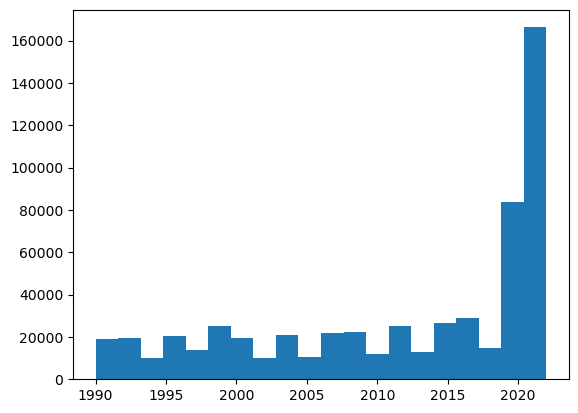

In [29]:
#Load in full data and see how much overlap there is
old_df = pd.read_excel('/Users/michaelfoley/Library/CloudStorage/GoogleDrive-mfoley@g.harvard.edu/My Drive/Subnational_Yield_Database/data/processed/IND/old_agstats/IN_AgStatsFeb2025_Gary.xlsx') 
plt.hist(old_df['Year'], bins=20)

In [30]:
new_names = new_df[new_df['Year'] == 2022]['Admin 2'].unique().astype(str)
old_names = old_df[old_df['Year'] == 2022]['Admin 2'].unique().astype(str)

In [31]:
unique_names = new_names[~np.isin(new_names,old_names)]

In [32]:
np.sort(new_names)

array(['Adilabad (TG)', 'Agar Malwa (MP)', 'Agra (UP)', 'Ahmedabad (GJ)',
       'Ahmednagar (MH)', 'Aizawl (MZ)', 'Ajmer (RJ)', 'Akola (MH)',
       'Alappuzha (KL)', 'Aligarh (UP)', 'Alipurduar (WB)',
       'Alirajpur (MP)', 'Allahabad (UP)', 'Alluri Sitharama Raju (AP)',
       'Almora (UK)', 'Alwar (RJ)', 'Ambala (HR)', 'Ambedkar Nagar (UP)',
       'Amethi (UP)', 'Amravati (MH)', 'Amreli (GJ)', 'Amritsar (PB)',
       'Amroha (UP)', 'Anakapalli (AP)', 'Anand (GJ)', 'Anantapur (AP)',
       'Anantnag (JK)', 'Angul (OD)', 'Anjaw (AR)', 'Annamayya (AP)',
       'Anuppur (MP)', 'Araria (BR)', 'Aravalli (GJ)', 'Ariyalur (TN)',
       'Arwal (BR)', 'Ashoknagar (MP)', 'Auraiya (UP)', 'Aurangabad (BR)',
       'Aurangabad (MH)', 'Ayodhya (UP)', 'Azamgarh (UP)',
       'Bagalkot (KA)', 'Bageshwar (UK)', 'Bagpat (UP)', 'Bahraich (UP)',
       'Baksa (AS)', 'Balaghat (MP)', 'Balangir (OD)', 'Balasore (OD)',
       'Ballari (KA)', 'Ballia (UP)', 'Balod (CG)', 'Baloda Bazar (CG)',
       'Bal

In [33]:
len(new_names)

746

In [34]:
np.sort(old_names)

array(['Adilabad (TG)', 'Agar Malwa (MP)', 'Agra (UP)', 'Ahmedabad (GJ)',
       'Ahmednagar (MH)', 'Aizawl (MZ)', 'Ajmer (RJ)', 'Akola (MH)',
       'Alappuzha (KL)', 'Aligarh (UP)', 'Alipurduar (WB)',
       'Alirajpur (MP)', 'Alluri Sitharama Raju (AP)', 'Almora (UK)',
       'Alwar (RJ)', 'Ambala (HR)', 'Ambedkar Nagar (UP)', 'Amethi (UP)',
       'Amravati (MH)', 'Amreli (GJ)', 'Amritsar (PB)', 'Amroha (UP)',
       'Anakapalli (AP)', 'Anand (GJ)', 'Anantapur (AP)', 'Anantnag (JK)',
       'Angul (OD)', 'Anjaw (AR)', 'Annamayya (AP)', 'Anuppur (MP)',
       'Araria (BR)', 'Aravalli (GJ)', 'Ariyalur (TN)', 'Arwal (BR)',
       'Ashoknagar (MP)', 'Auraiya (UP)', 'Aurangabad (BR)',
       'Aurangabad (MH)', 'Ayodhya (UP)', 'Azamgarh (UP)',
       'Bagalkot (KA)', 'Bageshwar (UK)', 'Bagpat (UP)', 'Bahraich (UP)',
       'Baksa (AS)', 'Balaghat (MP)', 'Balangir (OD)', 'Balasore (OD)',
       'Ballari (KA)', 'Ballia (UP)', 'Balod (CG)', 'Baloda Bazar (CG)',
       'Balrampur (UP)', 'Bal

In [37]:
unique_names

array(['Kadapa (AP)', 'nan', 'Gulbarga (KA)', 'Shimoga (KA)',
       'Bellary (KA)', 'Warangal (TG)', 'Warangal Urban (TG)',
       'Allahabad (UP)'], dtype='<U32')

In [ ]:

old = np.array([ 18961.,  19569.,   9881.,  20457.,  13681.,  25088.,  19687., 10267.,  20766.,  10404.,  21894.,  22318.,  11975.,  25245., 13112.,  26452.,  29171.,  14995.,  83583., 166302.])
new = np.array([ 18955.,  19560.,   9878.,  20439.,  18711.,  38241.,  33003., 17288.,  35129.,  17371.,  35889.,  37183.,  18605.,  38082., 19754.,  38798.,  43451.,  22427.,  98756., 179524.])

In [ ]:
#Ask Gary what might be going on here
plt.scatter(np.linspace(1, len(new - old), len(new - old)), new - old)

In [ ]:
np.sum(new - old)